# Processing biosignals in CNeuroMod Friends Dataset
## Physiological data preparation for Courtois-Neuromod
The notebook reviews general steps for the preparation of biosignals collected in the scanner (fMRI). We will first load information from processed biosignals, then we will inspect different layers of the pipeline in order to visualize the contribution of each of its parameters. We will give precedence to the PPG signal for parcimony. An example of each processed biosignal is given at the end. 

## Friends dataset
The Courtois-NeuroMod Friends dataset is a multimodal fMRI and biosignals free-viewing experiment where subject watched to 6 seasons of the Friends TV show. 

Physiological signals were collected throughout the BOLD acquisitions. They were recorded with the MRI-compatible acquisition system of BIOPAC (MP160) and the AcqKnowledge© software.

A total of five signals were recorded with the BIOPAC, including a trigger channel indicating the repetition time of the scanner (5V trigger signal with interval 1.49s). This trigger was used to synchronize the four recorded physiological modalities and the BOLD acquisitions with the stimuli from the task. 

The sampling frequency is the same for all physiological modalities, i.e. 10kHz.  

Cardiovascular activity was captured by photoplethysmography (PPG, with BIOPAC amplifier PPG100C). This allows the acquisition of pulsatile activity of the cardiovascular system. We also acquired electrocardiographic signals (ECG).

The PPG trace is an indirect measure of local blood volume and is used to detect the arterial pulse. The PPG is affected by motion artifacts, and (to a lesser extent than ECG) by magnetic field distortions. The PPG sensor was positioned on the hallux (big toe), except for one of our participants (sub-03), for whom the PPG sensor was placed on the ankle over the posterior tibial artery to obtain a more reliable pulse signal. 

A low-pass filter integrated in the amplifier ensures part of the denoising before the digitization of the signals. 

There are numerous features of interest in PPG. They can be used to regress autonomic activity from the fMRI signals, or be subjected to analyses themselves (Link to ISC).

### Summary:
1. Importing the physiological data information
2. Inspection of parameters effects
3. Visualization of artefacts and systolic peaks intervals

#### Dependencies

In [1]:
# these are utilities
import pandas as pd
import numpy as np
import os
import glob
import pickle
import pprintpp

In [2]:
# these are biosignal processing packages
import neurokit2 as nk
import systole
import heartpy as hp

In [3]:
# these are visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# here we set our parameters to render figures
%pylab inline
sns.set_style('darkgrid')
pylab.rcParams['figure.figsize'] = (12.0, 6.0)  
plt.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


# 1. Fetching physio data info
Loading all processed data. They come in the form of metadata-like dictionary objects in `.json` files

In [5]:
# data label
indir = "/scratch/flesp/physio_data/friends1/viz/"
root = "/scratch/flesp/physio_data/friends1/"
subs = ['sub-01', 'sub-02','sub-03', 'sub-04','sub-05', 'sub-06']

In [6]:
# Fetching stored data
# iterate through subjects/sessions and print progress
df = pd.DataFrame()
for s in sub:
    print(s)
    print("~"*30)
    meta = pd.read_json(f"{root}/{s}/{s}_volumes_all-ses-runs.json")
    
    for ses in meta.keys():
        print(f"Currently processing {ses}")
        json = glob.glob(f"{indir}{s}/{ses}/*.json")
        json.sort()
        if len(json)==0:
            print('empty session')
        # read each file in a subject/session
        for i, info in enumerate(json):
            here = info.rfind('task')
            there = info.rfind('_')
            task = info[here:there]
            with open(info, 'rb') as f:
                tmp = pickle.load(f)
            try:
                nb_vol=meta[ses][f"{i+1:02d}"]

                if nb_vol is np.nan:
                    nb_vol=int(0)
            except KeyError:
                print(f"skipping {ses} run-{i:02d}")
                continue
            print("fetching run info")
            # create a new row in the dataframe with artefacts count and mean interbeat interval
            new_row = {'ectopic':tmp['PPG_ectopic'], 
                       'short':tmp['PPG_short'], 'extra':tmp['PPG_extra'],
                       'long': tmp['PPG_long'], 'missed':tmp['PPG_missed'], 
                       'mean_rr_systole': np.mean(tmp['PPG_clean_rr_systole']),
                       'std_rr_systole': np.std(tmp['PPG_clean_rr_systole']),
                       'mean_rr_heartpy': np.mean(tmp['PPG_clean_rr_hp']),
                       'RSP_Phase': dict({'RSP_Peaks':tmp['RSP_Peaks'],'RSP_Troughs':tmp['RSP_Troughs']}),
                       'task': task, 'run_id': i+1, 'session_id':ses, 'subject': s,
                       'filename': json[i], 'nb_vol':int(nb_vol)}
            df = df.append(new_row,ignore_index=True)

#df.to_csv('result.csv')

sub-01
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently processing ses-001
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-002
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-003
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-004
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-005
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-006
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-007
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-008
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-009
fetching run info

fetching run info
fetching run info
fetching run info
Currently processing ses-037
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-038
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-039
empty session
Currently processing ses-040
empty session
Currently processing ses-041
empty session
Currently processing ses-042
empty session
Currently processing ses-043
empty session
sub-03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Currently processing ses-001
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-002
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-003
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-004
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-005
fetching run info
fetching run info
fetching run info
fetc

fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-015
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-016
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-017
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-018
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-019
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-020
empty session
Currently processing ses-021
empty session
Currently processing ses-022
fetching run info
fetching run info
Currently processing ses-023
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-02

/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-016
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-017
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-018
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-019
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-020
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
Currently processing ses-021
fetching run info
fetching run info
fetching run info
fetching run info
fetching run info
fetching run inf

In [7]:
quality_df = df[(df['mean_rr_systole']>1200) | ((df['mean_rr_heartpy']<700) & (df['mean_rr_systole']<600)) | (df['std_rr_systole']>300)]

for sub in subs:
    meta = pd.read_json(f"{root}/{sub}/{sub}_volumes_all-ses-runs.json")
    
    runs = {}
    ses_to_check = quality_df['session_id'][quality_df['subject']==sub].unique()
    for ses in ses_to_check:
        runs[ses] = list(quality_df['run_id'][quality_df['session_id']==ses])
    for ses in ses_to_check:
        for i in runs[ses]:
            triggers=list(meta[ses]['recorded_triggers'].values())
            triggers=list(np.concatenate(triggers).flat)
            try:
                pprintpp.pprint([sub, ses, int(i),meta[ses]['task'][int(i)], triggers[int(i)], quality_df[(quality_df['subject']==sub) &(quality_df['session_id']==ses) & (quality_df['run_id']==i)]['mean_rr_systole'],
                                 quality_df[(quality_df['subject']==sub) &(quality_df['session_id']==ses) & (quality_df['run_id']==i)]['std_rr_systole']])
                
            except IndexError:
                print(sub, ses, int(i), triggers)

[
    'sub-02',
    'ses-001',
    2,
    'task-s01e02a',
    482,
    191    599.58124
    Name: mean_rr_systole, dtype: float64,
    191    59.215592
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-02',
    'ses-001',
    3,
    'task-s01e02b',
    482,
    192    588.722254
    Name: mean_rr_systole, dtype: float64,
    192    64.579291
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-02',
    'ses-001',
    4,
    'task-s01e03a',
    472,
    193    580.027858
    Name: mean_rr_systole, dtype: float64,
    193    67.785433
    Name: std_rr_systole, dtype: float64,
]
[
    'sub-02',
    'ses-001',
    5,
    'task-s01e03b',
    472,
    194    564.995839
    Name: mean_rr_systole, dtype: float64,
    194    70.27067
    Name: std_rr_systole, dtype: float64,
]
sub-02 ses-001 6 [3, 42, 482, 482, 472, 472, 503, 503]
[
    'sub-02',
    'ses-001',
    3,
    'task-s01e02b',
    482,
    192    588.722254
    Name: mean_rr_systole, dtype: float64,
    192    64.579291
    Na

sub-03 ses-046 4 [3, 5, 447, 447, 444, 444]
sub-03 ses-047 4 [3, 487, 487, 478, 478]
sub-03 ses-049 4 [3, 447, 447, 448, 448]
sub-03 ses-051 2 [3, 505, 504]
[
    'sub-03',
    'ses-052',
    3,
    'task-s04e23d',
    504,
    539    1412.324236
    Name: mean_rr_systole, dtype: float64,
    539    1822.176938
    Name: std_rr_systole, dtype: float64,
]
sub-03 ses-052 4 [3, 33, 505, 504, 504, 504]
[
    'sub-03',
    'ses-058',
    1,
    'task-s05e11b',
    476,
    557    3748.359122
    Name: mean_rr_systole, dtype: float64,
    557    4279.877173
    Name: std_rr_systole, dtype: float64,
]
sub-03 ses-058 2 [3, 476, 511]
[
    'sub-03',
    'ses-059',
    1,
    'task-s05e12b',
    190,
    559    1059.915445
    Name: mean_rr_systole, dtype: float64,
    559    458.014308
    Name: std_rr_systole, dtype: float64,
]
sub-03 ses-059 2 [3, 190, 3, 445, 480]
[
    'sub-03',
    'ses-060',
    2,
    'task-s05e14a',
    494,
    562    881.934094
    Name: mean_rr_systole, dtype: float6

In [10]:
clean_df = df.drop(df[(df['mean_rr_systole']>1200) | ((df['mean_rr_heartpy']<700) & (df['mean_rr_systole']<600)) | (df['std_rr_systole']>300)].index)
#clean_df = df
#clean_df.to_csv("/scratch/flesp/physio_data/friends1/pilot_hr-isc.csv")

In [27]:
ok_task=[]
for task in pd.unique(clean_df['task'].unique()):
    tmp = clean_df[clean_df['task']==task]
    if len(tmp)>=2:
        ok_task.append(task)
        
print(len(ok_task), len(pd.unique(clean_df['task'].unique())))

211 237


In [28]:
ok_task.sort()

In [29]:
ok_task

['',
 'task-s01e01a',
 'task-s01e01b',
 'task-s01e02a',
 'task-s01e02b',
 'task-s01e03a',
 'task-s01e03b',
 'task-s01e04a',
 'task-s01e04b',
 'task-s01e05a',
 'task-s01e05b',
 'task-s01e06a',
 'task-s01e06b',
 'task-s01e07a',
 'task-s01e07b',
 'task-s01e08a',
 'task-s01e08b',
 'task-s01e09a',
 'task-s01e09b',
 'task-s01e10a',
 'task-s01e10b',
 'task-s01e11a',
 'task-s01e11b',
 'task-s01e12a',
 'task-s01e12b',
 'task-s01e13a',
 'task-s01e13b',
 'task-s01e14a',
 'task-s01e14b',
 'task-s01e15a',
 'task-s01e15b',
 'task-s01e16a',
 'task-s01e16b',
 'task-s01e17a',
 'task-s01e17b',
 'task-s01e18a',
 'task-s01e18b',
 'task-s01e19a',
 'task-s01e19b',
 'task-s01e20a',
 'task-s01e20b',
 'task-s01e21a',
 'task-s01e21b',
 'task-s01e22a',
 'task-s01e22b',
 'task-s01e23a',
 'task-s01e23b',
 'task-s01e24a',
 'task-s01e24b',
 'task-s02e01a',
 'task-s02e01b',
 'task-s02e02a',
 'task-s02e02b',
 'task-s02e03a',
 'task-s02e03b',
 'task-s02e04a',
 'task-s02e04b',
 'task-s02e05a',
 'task-s02e05b',
 'task-s0

# 2. Step-by-step processing of PPG data
## 2.1 Using high-level processing function

#### Import home functions

In [31]:
%run ~/cneuromod/ds_prep/physio/preproc/neuromod_process.py

#### Fetch data

In [32]:
fn = "/scratch/flesp/physio_data/friends1/sub-01/sub-01_volumes_all-ses-runs.json"
metadata = pd.read_json(fn)
filename = "/scratch/flesp/physio_data/friends1/sub-01/ses-020/sub-01_ses-020_task-s03e06a_physio"
fig_name = filename[filename.rfind('/')+1:]

In [33]:
json=pd.read_json(f"{filename}.json")
fs = json['SamplingFrequency'][0]

In [34]:
bio_df = pd.read_csv(f"{filename}.tsv.gz",
                     sep='\t',
                     compression='gzip',
                     header=None,
                     names=json.Columns)

#### Processing function for neuromod PPG

In [35]:
signals, info_corrected = neuromod_ppg_process(bio_df['PPG'], fs)

PPG Cleaned
HeartPy processing started

Finished in 26.98685 sec
Heartpy found peaks
Neurokit found peaks
Cleaning the RR interval time series using 4 iterations.
 - Iteration 1 - 
... correcting 6 missed interval(s).
... correcting 10 ectopic interval(s).
... correcting 1 short interval(s).
... correcting 1 long interval(s).
 - Iteration 2 - 
 - Iteration 3 - 
 - Iteration 4 - 
Cleaning the peaks vector using 4 iterations.
 - Iteration 1 - 
... correcting 6 missed peak(s).
 - Iteration 2 - 
 - Iteration 3 - 
 - Iteration 4 - 
systole corrected RR series


### Output of cardiac processing function

In [36]:
signals.head()

,PPG_Raw,PPG_Clean,PPG_Peaks_NK,PPG_Peaks_HP,PPG_Peaks_Systole,PPG_Rate
0,-0.035095,-0.001546,0.0,0.0,False,65.107209
1,-0.036316,-0.001539,0.0,0.0,False,65.107209
2,-0.035706,-0.001531,0.0,0.0,False,65.107209
3,-0.036011,-0.001524,0.0,0.0,False,65.107209
4,-0.035706,-0.001516,0.0,0.0,False,65.107209


In [37]:
info_corrected.keys()

dict_keys(['PPG_Peaks', 'PPG_ectopic', 'PPG_short', 'PPG_clean_rr_systole', 'PPG_clean_rr_hp', 'PPG_long', 'PPG_extra', 'PPG_missed', 'PPG_rejected_segments', 'PPG_Peaks_corrected', 'PPG_cumulseconds_rejected', 'PPG_%_rejected_segments'])

## Interactive visualization
### Raw signal

In [38]:
plot = systole.plots.plot_raw(signals['PPG_Raw'], backend='bokeh', show_heart_rate=True, show_artefacts=True, sfreq=fs)

In [39]:
from bokeh.io import output_notebook
from bokeh.plotting import show, output_file, save
output_notebook()

show(plot)

Loading BokehJS ...

### Corrected RR timeseries

In [40]:
plot_rr = systole.plots.plot_rr(info_corrected['PPG_clean_rr_systole'],input_type='rr_ms',backend='bokeh', show_artefacts=True)

In [41]:
output_notebook()

show(plot_rr)

Loading BokehJS ...

## Breaking down the high-level processing function
### Visualizing the effect of each step in the procedure with 20 seconds

In [43]:
signal = signals['PPG_Raw']
filt = nk.signal_filter(signal, fs, lowcut=0.5, highcut=8, order=3)

Text(0.5, 1.0, 'RAW PPG')

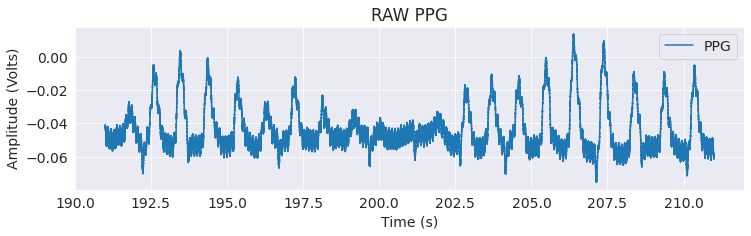

In [89]:
fig=bio_df[['PPG','time']][2000000:2200000].plot(x='time', figsize=(12,3))
plt.ylabel('Amplitude (Volts)')
plt.xlabel('Time (s)')
plt.title("RAW PPG")

Text(0.5, 1.0, 'FILTERED PPG')

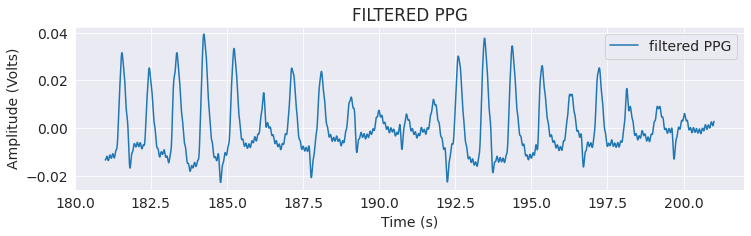

In [90]:
df_filt = pd.DataFrame({'time': bio_df['time'], 'filtered PPG':filt})
df_filt[1900000:2100000].plot(x='time', figsize=(12,3))
plt.ylabel('Amplitude (Volts)')
plt.xlabel('Time (s)')
plt.title("FILTERED PPG")

### Detection of systolic peaks

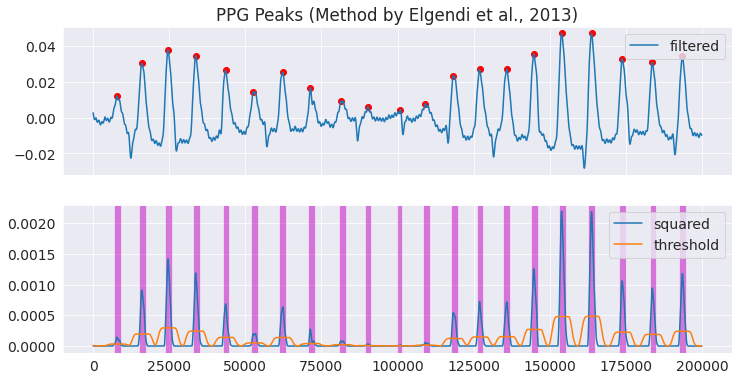

In [91]:
info = nk.ppg_findpeaks(filt[2000000:2200000], fs, show=True)

### Visualizing artifact detection

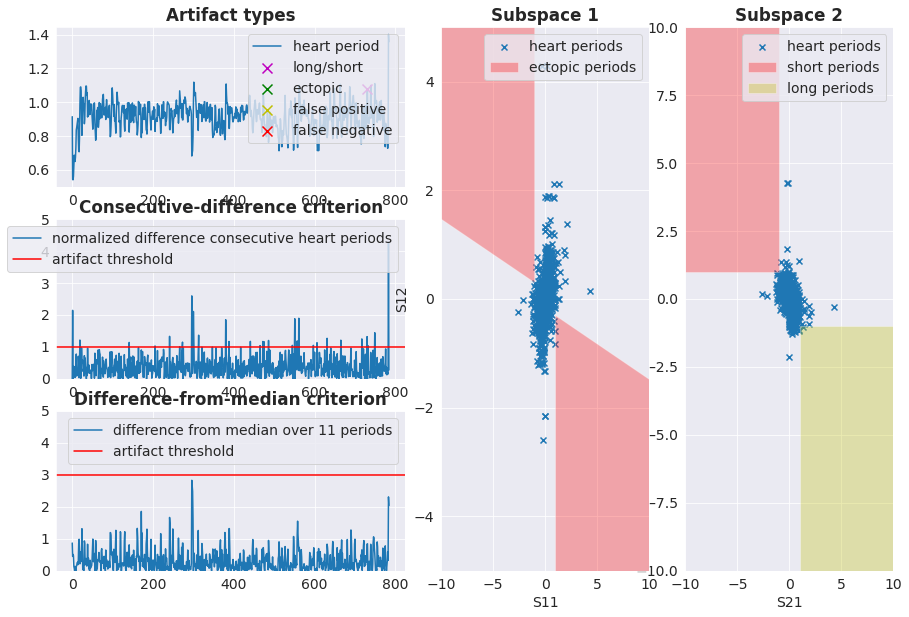

In [99]:
info = nk.ppg_findpeaks(filt, fs)
artefacts, info1 = nk.signal_fixpeaks(info, sampling_rate=fs,  iterative=True, show=True, method="Kubios")

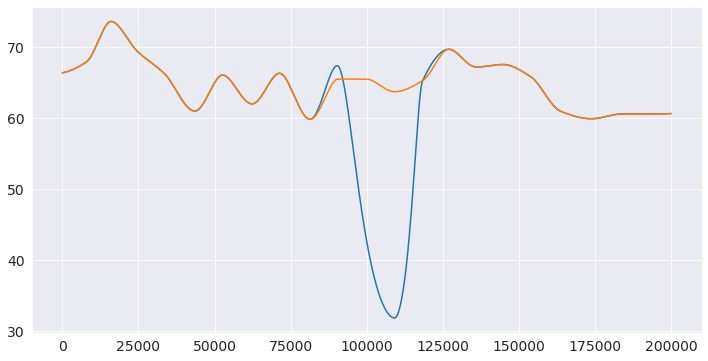

In [102]:
rate_corrected = nk.signal_rate(info1,fs, desired_length=len(bio_df))
rate_uncorrected = nk.signal_rate(info,fs, desired_length=len(bio_df))
fig, ax = plt.subplots()
ax.plot(rate_uncorrected[2000000:2200000])
ax.plot(rate_corrected[2000000:2200000])


# Visualize overall quality of PPG 
Average number of detected artifacts per run, arranged by artifact type

## Ectopic intervals

<AxesSubplot:xlabel='subject', ylabel='ectopic'>

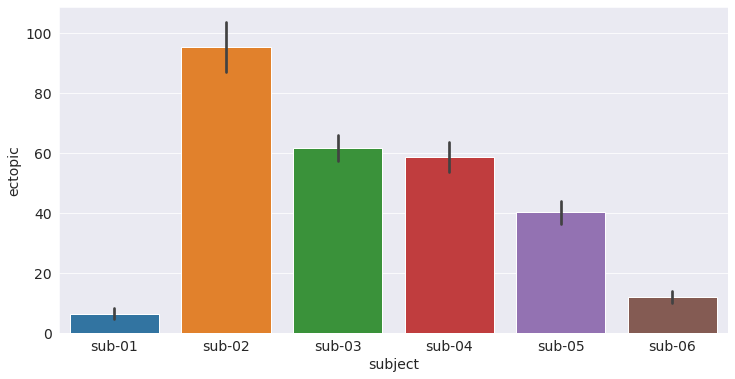

In [105]:
sns.barplot(data=clean_df, x='subject', y='ectopic')

## Long intervals

<AxesSubplot:xlabel='subject', ylabel='long'>

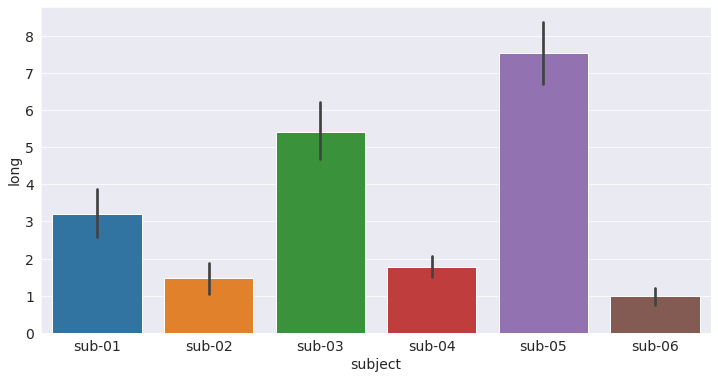

In [106]:
sns.barplot(data=clean_df, x='subject', y='long')

## Short intervals

<AxesSubplot:xlabel='subject', ylabel='short'>

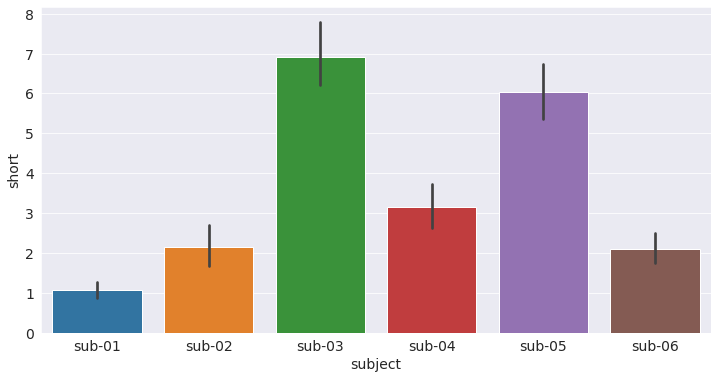

In [107]:
sns.barplot(data=clean_df, x='subject', y='short')

## Missed beat

<AxesSubplot:xlabel='subject', ylabel='missed'>

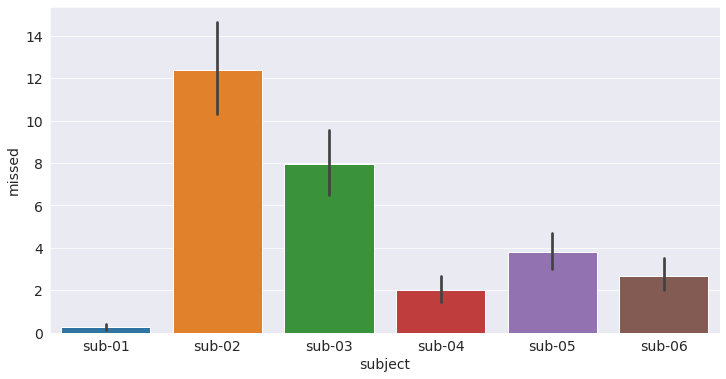

In [108]:
sns.barplot(data=clean_df, x='subject', y='missed')

## Extra beats

<AxesSubplot:xlabel='subject', ylabel='extra'>

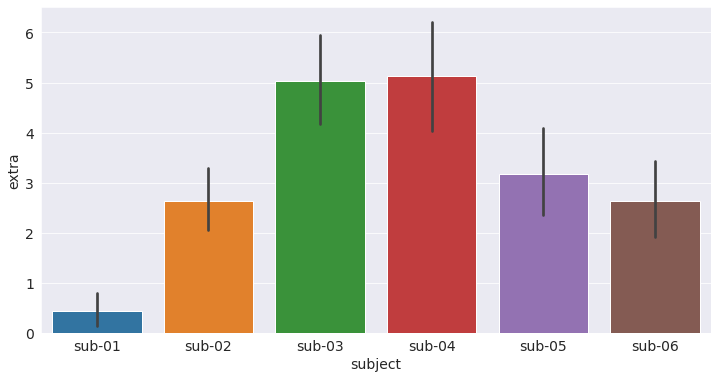

In [109]:
sns.barplot(data=clean_df, x='subject', y='extra')

## Distributions of average RR interval across runs
### Systole

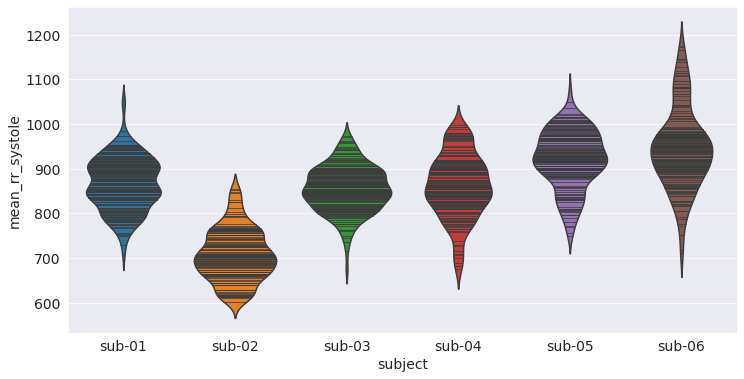

In [39]:
dist = sns.violinplot(data=clean_df, x='subject',y='mean_rr_systole', inner='stick', bw=0.3)

### HeartPy

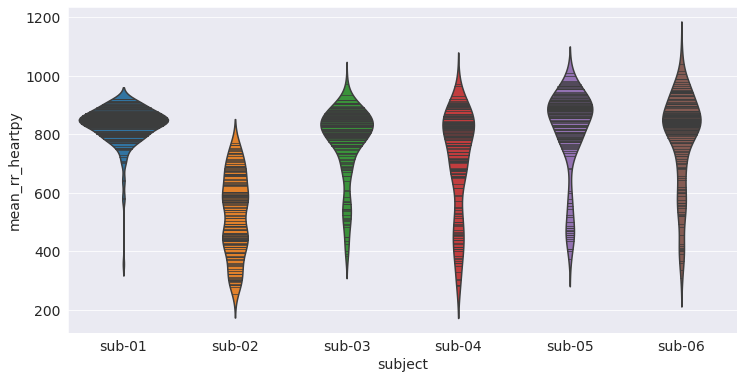

In [40]:
dist = sns.violinplot(data=clean_df, x='subject',y='mean_rr_heartpy', inner='stick', bw=0.3)

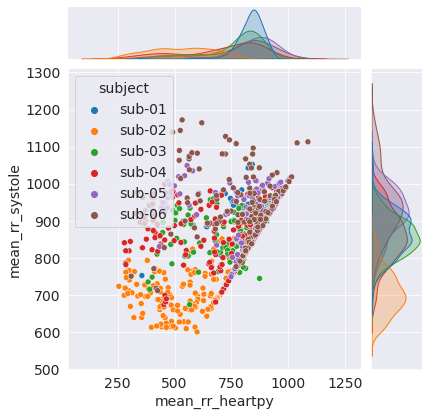

In [54]:
sns.jointplot(x='mean_rr_heartpy', y='mean_rr_systole',hue='subject', data=clean_df)

In [ ]:
# Initialize the FacetGrid object
pal = sns.color_palette('magma', n_colors=6, desat=.7)
pal = reversed(pal)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(clean_df, row="subject", hue="subject", aspect=12, height=.9, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean_rr_systole",
      bw_adjust=.7, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "mean_rr_systole", clip_on=False, color="w", lw=.4, bw_adjust=.7)

# passing color=None to refline() uses the hue mapping
g.refline(y=-.000001, linewidth=3, linestyle="-", color=None, clip_on=True)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.05, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "mean_rr_systole")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.xlabel('Mean pulse interval (ms)')
plt.savefig('RRi_distribution.png', bbox_inches='tight', dpi=300)

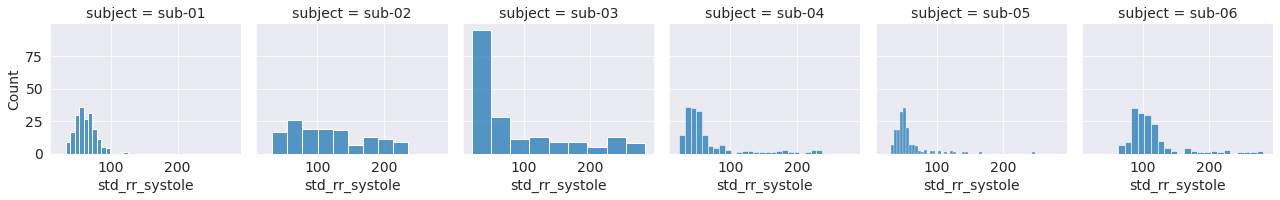

In [110]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "std_rr_systole", )

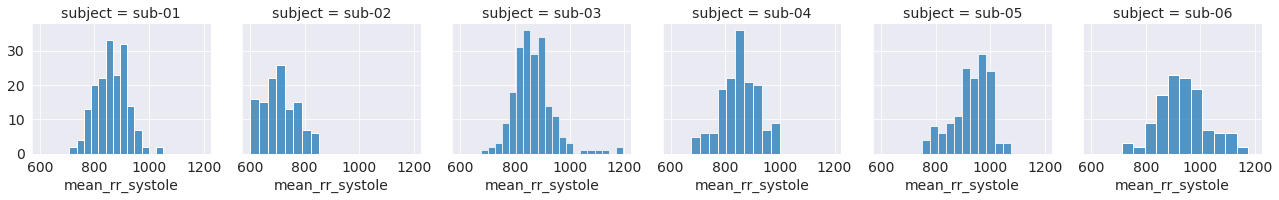

In [40]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "mean_rr_systole", )

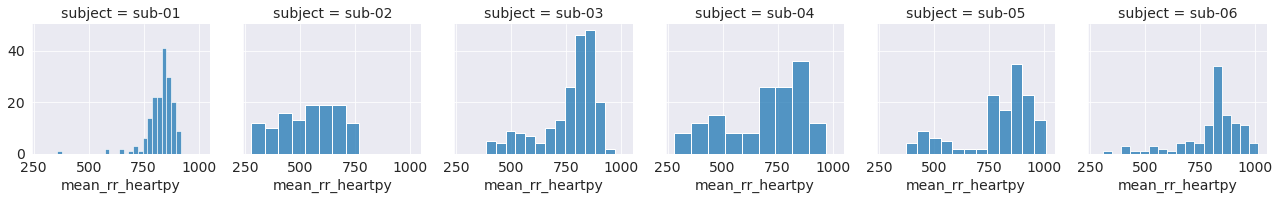

In [41]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "mean_rr_heartpy")

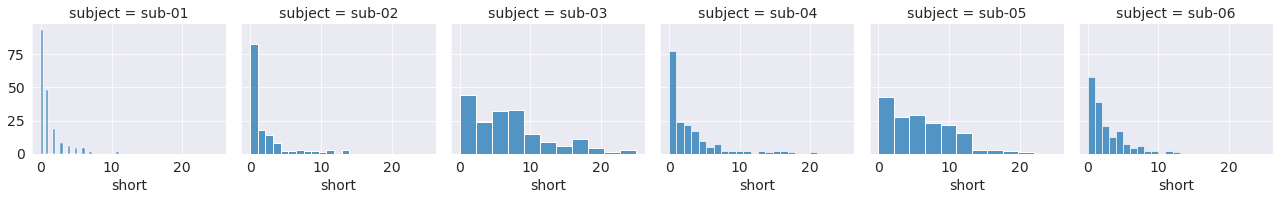

In [49]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "short", )

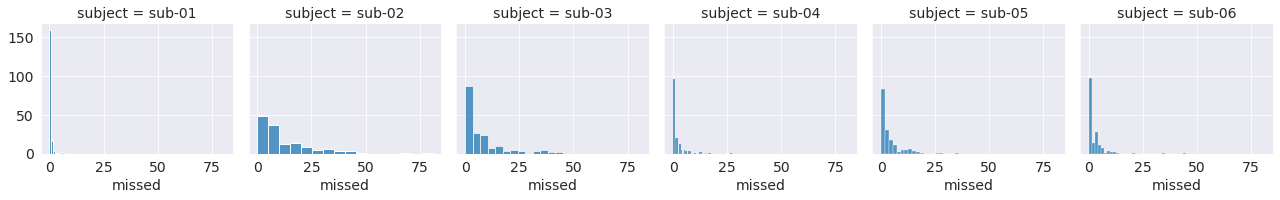

In [50]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "missed", )

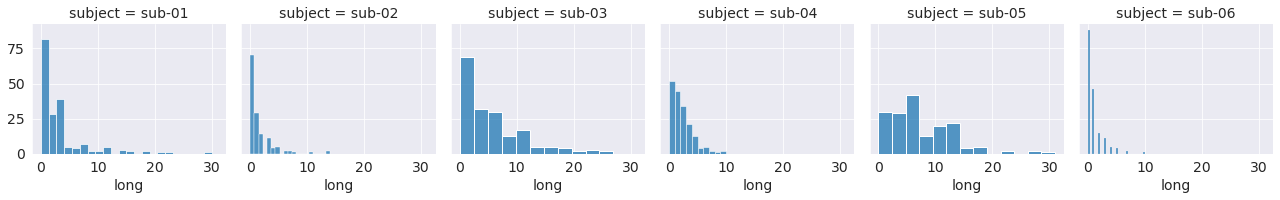

In [51]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "long", )

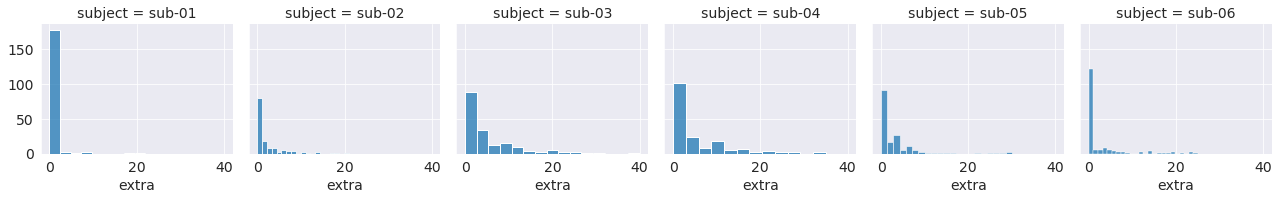

In [52]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "extra", )

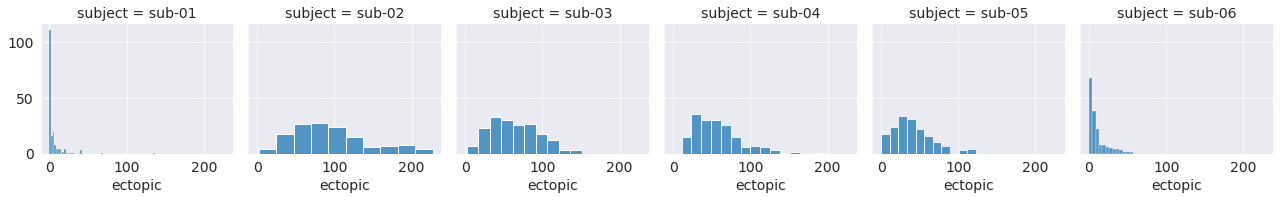

In [53]:
g = sns.FacetGrid(clean_df, col="subject", palette='Set3' )
g.map(sns.histplot, "ectopic", )

# 3. Processing of all biosignals

In [111]:
bio_proc, bio_info = neuromod_bio_process(df=bio_df, sampling_rate=fs)

Reading pandas DataFrame
PPG Cleaned
HeartPy processing started

Finished in 26.67664 sec
Heartpy found peaks
Neurokit found peaks
Cleaning the RR interval time series using 4 iterations.
 - Iteration 1 - 
... correcting 6 missed interval(s).
... correcting 10 ectopic interval(s).
... correcting 1 short interval(s).
... correcting 1 long interval(s).
 - Iteration 2 - 
 - Iteration 3 - 
 - Iteration 4 - 
Cleaning the peaks vector using 4 iterations.
 - Iteration 1 - 
... correcting 6 missed peak(s).
 - Iteration 2 - 
 - Iteration 3 - 
 - Iteration 4 - 
systole corrected RR series
Respiration workflow: done
Electrodermal activity workflow: done


In [112]:
bio_proc.keys()

Index(['PPG_Raw', 'PPG_Clean', 'PPG_Peaks_NK', 'PPG_Peaks_HP',
       'PPG_Peaks_Systole', 'PPG_Rate', 'ECG', 'RSP_Raw', 'RSP_Clean',
       'RSP_Amplitude', 'RSP_Rate', 'RSP_RVT', 'RSP_Phase',
       'RSP_Phase_Completion', 'RSP_Symmetry_PeakTrough',
       'RSP_Symmetry_RiseDecay', 'RSP_Peaks', 'RSP_Troughs', 'EDA_Raw',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery',
       'SCR_RecoveryTime', 'TTL', 'time'],
      dtype='object')

In [113]:
bio_info.keys()

dict_keys(['PPG_Peaks', 'PPG_ectopic', 'PPG_short', 'PPG_clean_rr_systole', 'PPG_clean_rr_hp', 'PPG_long', 'PPG_extra', 'PPG_missed', 'PPG_rejected_segments', 'PPG_Peaks_corrected', 'PPG_cumulseconds_rejected', 'PPG_%_rejected_segments', 'RSP_Peaks', 'RSP_Troughs', 'sampling_rate', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'])

Text(0.5, 0, 'time (s)')

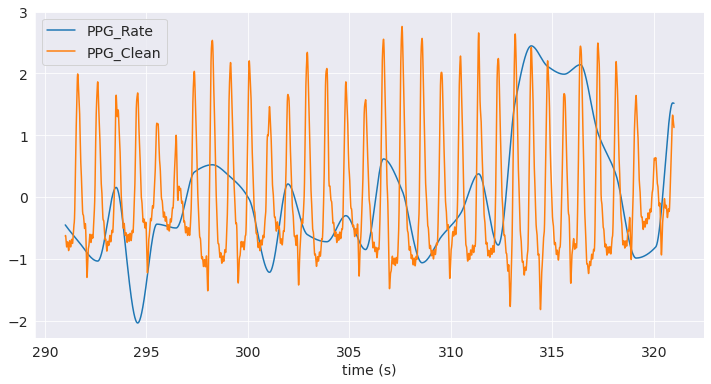

In [114]:
df1 = nk.standardize(bio_proc[['PPG_Rate', 'PPG_Clean']][3000000:3300000])
df1['time'] = bio_proc['time'][3000000:3300000]
df1.plot(x='time')
plt.xlabel('time (s)')

<AxesSubplot:xlabel='time'>

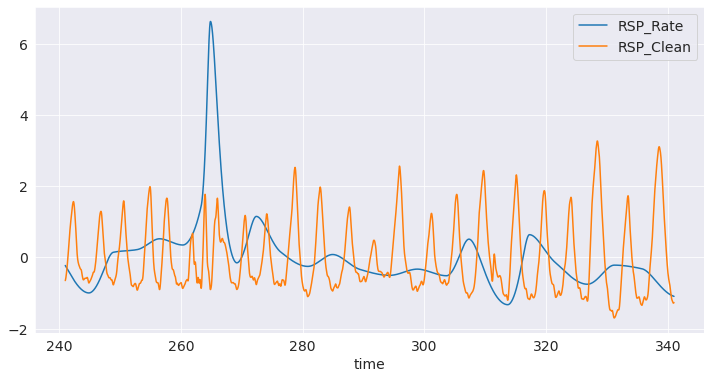

In [115]:
df1 = nk.standardize(bio_proc[['RSP_Rate', 'RSP_Clean']][2500000:3500000])
df1['time'] = bio_proc['time'][2500000:3500000]
df1.plot(x='time')

<AxesSubplot:xlabel='time'>

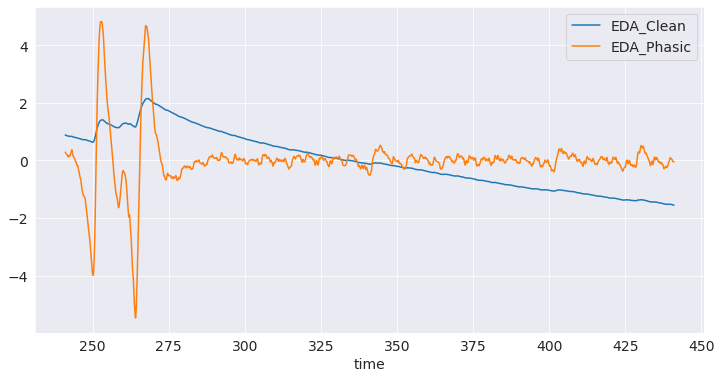

In [116]:
df1 = nk.standardize(bio_proc[['EDA_Clean', 'EDA_Phasic']][2500000:4500000])
df1['time'] = bio_proc['time'][2500000:4500000]
df1.plot(x='time')